from https://www.kaggle.com/datasets/mazlumi/mbti-personality-type-twitter-dataset/code

In [1]:
#!pip install pandas

In [2]:
import pandas as pd

In [3]:
df=pd.read_csv('twitter_MBTI.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7811 entries, 0 to 7810
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  7811 non-null   int64 
 1   text        7811 non-null   object
 2   label       7811 non-null   object
dtypes: int64(1), object(2)
memory usage: 183.2+ KB


(7811, 3)


<Axes: >

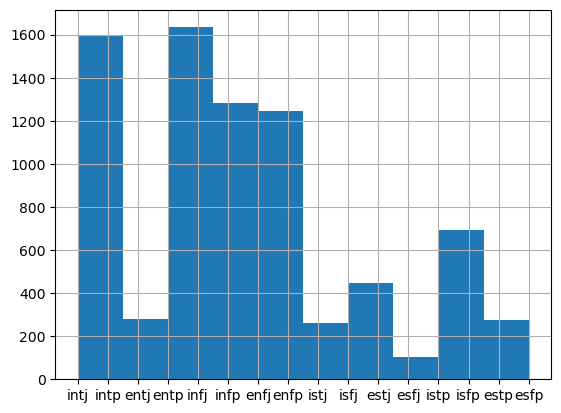

In [4]:
print(df.shape)
df.label.hist()

In [5]:
# nb each text contains multiple tweets seperated with ||| Was going to burst these, but don'tthink it adds value
# but definitely works removing @handles, and urls (probably)
import re
def rmhand(s):
    return re.sub('@[^\s]*','',s)
def rmurl(s):
    return re.sub('https://[^\s]*','',s)
def rmtags(s):
    return re.sub('#','',s)
def rmpipes(s):
    return re.sub('\|\|','',s)

def clean_tweets(s):
    s=s.apply( rmhand )
    s=s.apply(rmurl)
    s=s.apply(rmtags)
    s=s.apply(rmpipes)
    s=s.apply(lambda x:x.lower())
    return s
test=pd.Series(['xxx @yz zzz','start https://spug end || more'])
clean_tweets(test)
df.text=clean_tweets(df.text)

['intj' 'intp' 'entj' 'entp' 'infj' 'infp' 'enfj' 'enfp' 'istj' 'isfj'
 'estj' 'esfj' 'istp' 'isfp' 'estp' 'esfp']
intj (81, 3)
intp (161, 3)
entj (241, 3)
entp (321, 3)
infj (401, 3)
infp (481, 3)
enfj (561, 3)
enfp (641, 3)
istj (721, 3)
isfj (801, 3)
estj (881, 3)
esfj (961, 3)
istp (1041, 3)
isfp (1121, 3)
estp (1201, 3)
esfp (1281, 3)


<Axes: >

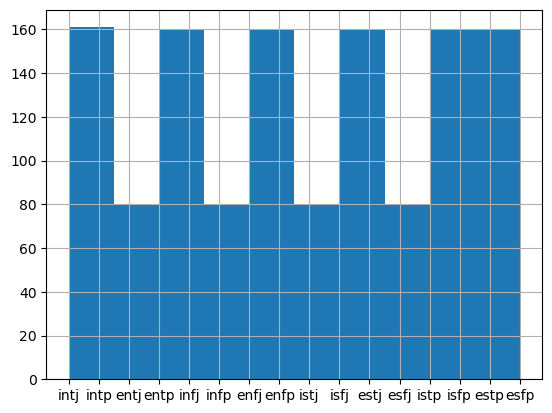

In [6]:
# get fully balanced sample
# firstly get labels
types=df.label.unique()
print(types)
# then get nsamp of each
nsamp=80
t='intj'
df.query('label=="'+t+'"')
working_df=df.head(1)
for t in types:    
    working_df=pd.concat([working_df,df.query('label=="'+t+'"').sample(nsamp)])
    print(t,working_df.shape)
# clean it
working_df.text=clean_tweets(working_df.text)
working_df.label.hist()  
    

In [7]:
# rescale with tf-idf
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer=TfidfVectorizer(min_df=5, stop_words='english',ngram_range=(1,1),norm=None).fit(working_df.text)
X = vectorizer.transform(working_df.text)
y=working_df.label
# find maximum value for each of the features over dataset:
max_value = X.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# get feature names
feature_names = np.array(vectorizer.get_feature_names_out())
print(f'{len(feature_names)} features')
print("Features with lowest tfidf:\n{}".format(
      feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
      feature_names[sorted_by_tfidf[-40:]]))

12939 features
Features with lowest tfidf:
['stayed' 'fool' 'dangerous' 'accident' 'beating' 'prepared' 'costs'
 'realizing' 'talks' 'smiles' 'waited' 'experienced' 'effects' 'threw'
 'habit' 'supportive' 'walls' 'dates' 'butter' 'tip']
Features with highest tfidf: 
['darling' 'winwin' 'enhypen' 'minted' '33' 'live' 'manifesto_day1'
 'stayc' 'ny' 'nayeon' 'list' 'unnie' 'sumin' 'followed' 'peer' '17'
 'jungwon' 'follow' 'aye' 'introverts' 'track' 'unfollowed' 'seventeen'
 'jhope' 'introvert' 'photography' 'checked' 'jackinthebox' 'jhope_more'
 'automatically' 'sector' 'yu' '세븐틴' '10' 'aries' 'sector17_d14' 'cheng'
 'hua' 'loveisland' 'meow']


In [8]:
from sklearn.model_selection import train_test_split
# setup for fitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
# vect = CountVectorizer().fit(text_train)
# X_train = vect.transform(text_train)
# print("X_train:\n{}".format(repr(X_train)))

In [10]:
feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

NameError: name 'vect' is not defined

In [11]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.tree import DecisionTreeClassifier # 0.38
from sklearn.neighbors import KNeighborsClassifier # brutal
from sklearn.neural_network import MLPClassifier # poor 0.12
from sklearn.ensemble import RandomForestClassifier # 0.4
from sklearn.metrics import classification_report
#scores = cross_val_score(LogisticRegression(max_iter=500), X_train, y_train, cv=2)
#print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))
reg=RandomForestClassifier().fit(X_train, y_train)
y_pred=reg.predict(X_test)
print(classification_report(y_pred,y_test,target_names=types))

              precision    recall  f1-score   support

        intj       0.43      0.46      0.44        26
        intp       0.30      0.56      0.39        18
        entj       0.74      0.55      0.63        31
        entp       0.44      0.74      0.55        19
        infj       0.32      0.17      0.23        40
        infp       0.50      0.18      0.27        61
        enfj       0.22      0.29      0.25        17
        enfp       0.29      0.64      0.40        11
        istj       0.37      0.46      0.41        24
        isfj       0.36      0.50      0.42        20
        estj       0.39      0.39      0.39        23
        esfj       0.62      0.65      0.64        23
        istp       0.62      0.38      0.48        39
        isfp       0.37      0.36      0.36        28
        estp       0.24      0.47      0.32        15
        esfp       0.35      0.39      0.37        28

    accuracy                           0.40       423
   macro avg       0.41   

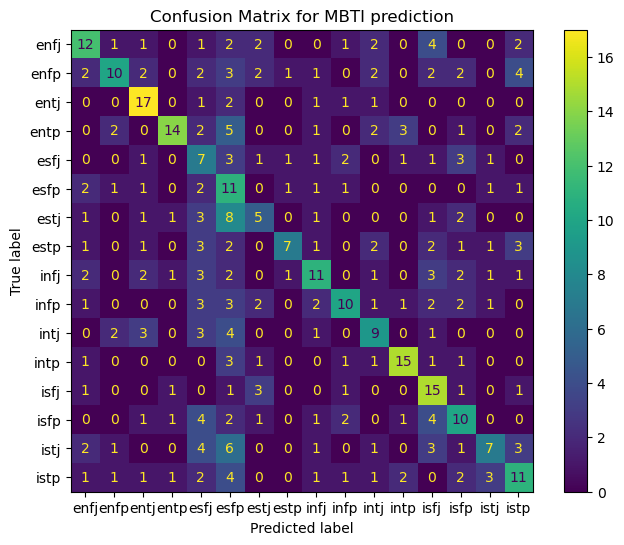

In [12]:
from sklearn.metrics import confusion_matrix

# Order of the input parameters is important: 
# first param is the actual output values
# second param is what our model predicted
conf_matrix = confusion_matrix(y_test, y_pred)

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Change figure size and increase dpi for better resolution
# and get reference to axes object
fig, ax = plt.subplots(figsize=(8,6), dpi=100)

# initialize using the raw 2D confusion matrix 
# and output labels (in our case, it's 0 and 1)
display = ConfusionMatrixDisplay(conf_matrix, display_labels=reg.classes_)

# set the plot title using the axes object
ax.set(title='Confusion Matrix for MBTI prediction')

# show the plot. 
# Pass the parameter ax to show customizations (ex. title) 
display.plot(ax=ax);

In [14]:
!pip install happybase

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 643.4/643.4 kB 1.7 MB/s eta 0:00:00 MB/s eta 0:00:01:01
  Preparing metadata (setup.py) ... done
  Created wheel for happybase: filename=happybase-1.2.0-py2.py3-none-any.whl size=26604 sha256=7c5655bed6b5e84f0ae70f749819249dd98ba6d6600803b1a533e454bbcc0a6c
  Stored in directory: /home/hduser/.cache/pip/wheels/9a/27/7b/f53cd56678a818d535097bffa4092086b41d0404781ffbc640
  Created wheel for thriftpy2: filename=thriftpy2-0.4.16-cp310-cp310-linux_x86_64.whl size=511370 sha256=4de101db3efd24e6c025f5325492dd8e160b6445acfde3d944a591e4caee2211
  Stored in directory: /home/hduser/.cache/pip/wheels/c1/26/64/cbf22aaa52bcd7c2e3201a3ecfaa0a82c5ca1887369168e2ca
Successfully built happybase thriftpy2


In [56]:
import happybase

connection = happybase.Connection('localhost')
table = connection.table('wordcount')

In [59]:
rows = table.scan()

In [60]:
connection.tables()

[b'wordcount']

In [61]:
# furthermore
data = [row[1] for row in rows]     

In [62]:
df = pd.DataFrame(data)

In [63]:
df.shape

(881776, 3)

In [64]:
df.head()

,b'cf:count',b'cf:label',b'cf:word'
0,b'342',b'!',b'enfj'
1,b'3',b'!!!!!!!!!!!',b'enfj'
2,b'2',"b'""best'",b'enfj'
3,b'2',b'#celebratelife',b'enfj'
4,b'16',b'barbie',b'enfj'
